In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
# import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import math

rng = np.random.default_rng(51)


In [7]:
df = pd.read_csv('letter-recognition.data', header=None)


In [8]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [17]:
le = preprocessing.LabelEncoder()
for column_name in df.columns:
    df[column_name] = le.fit_transform(df[column_name])
y = df[0]
X = df.loc[:, df.columns != 0]

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is

0        19
1         8
2         3
3        13
4         6
         ..
19995     3
19996     2
19997    19
19998    18
19999     0
Name: 0, Length: 20000, dtype: int64

In [147]:
feature_num = X.shape[1]
classes_num = len(pd.unique(y))
rows_num = len(X)
#лепим индикаторную функцию
y_26_outs = np.zeros((rows_num, classes_num))
for i in range(rows_num):
    y_26_outs[i][y[i]] = 1
X_arr = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_arr, y_26_outs, test_size=0.3, random_state=42)


In [148]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def cross_entropy_multiclass(y_pred, y_true):
    loss = 0

    for m in range(len(y_pred[0])):
        for n in range(len(y_pred)):
            loss += -1 * y_true[n][m] * np.log(y_pred[n][m])

    return loss / len(y_pred)


In [381]:
class VasKhumLogisticRegression:
    def __init__(self, feature_num, classes_num, learning_rate):
        self.feature_num = feature_num
        self.classes_num = classes_num
        self.W = self._init_weights()
        self.b = self._init_biases()
        self.lr = learning_rate
        # functions
        self.activation_fn = softmax
        self.loss_fn = self.cross_entropy_multiclass

    def cross_entropy_multiclass(self, y_pred, y_true):
        loss = 0
        epsilon = 1e-10

        for n in range(len(y_pred)):
            for m in range(len(y_pred[0])):
                loss += -1 * y_true[n][m] * np.log(y_pred[n][m] + epsilon)

        return loss / len(y_pred)

    def _init_weights(self):
        net_in = self.feature_num
        net_out = self.classes_num
        limit = np.sqrt(6. / (net_in + net_out))
        return rng.uniform(-limit, limit + 1e-5, size=(self.classes_num, self.feature_num))

    def _init_biases(self):
        return rng.random((self.classes_num, 1)) * 2 - 1

    def _compute_loss(self, X, y):
        y_pred = self.predict(X)
        y = np.array(y)
        res = self.loss_fn(y_pred, y)
        return res

    def _feedforward(self, X):
        self.a = np.zeros((len(X), self.classes_num))
        self.y = np.zeros((len(X), self.classes_num))
        for i in range(len(X)):
            self.a[i] = np.matmul(self.W, X[i]) + self.b.squeeze()
            self.y[i] = softmax(self.a[i])

    def _correct_weights(self, X, y):
        grad_weights = np.transpose(np.matmul(np.transpose(X), (self.y - y)))
        grad_biases = np.sum(self.y-y, axis=0)
        self.W = self.W - self.lr * grad_weights
        self.b = self.b.squeeze() - self.lr * grad_biases
        return

    def fit(self, X, y, epochs=1):
        epoch_losses = np.array([])
        for i in range(epochs):
            self._feedforward(X)
            self._correct_weights(X, y)
            epoch_losses = np.append(epoch_losses, self._compute_loss(X, y))
        return epoch_losses

    def predict(self, X):
        self._feedforward(X)
        y_pred = self.y
        return y_pred


In [369]:
def indicator_for_arr(arr):
    arr_1d = np.zeros(len(arr))
    for i in range(len(arr)):
        arr_1d[i] = arr[i].argmax()
    return arr_1d

First epoch loss - 20.071099719772697
Last epoch loss - 13.45757430168037


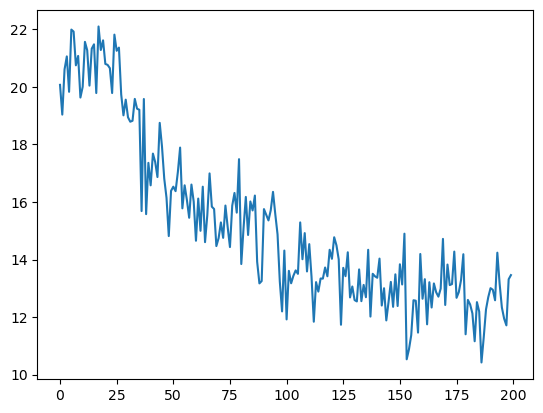

In [366]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 200)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

First epoch loss - 16.3730355351437
Last epoch loss - 14.220099628575506

Classification report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.69      0.52      0.60       330
         4.0       0.52      0.28      0.36       439
         5.0       0.00      0.00      0.00         0
         6.0       0.16      0.66      0.26        56
         7.0       0.00      0.00      0.00         0
         8.0       0.09      1.00      0.17        20
         9.0       0.81      0.33      0.46       568
        10.0       0.80      0.18      0.29       854
        11.0       0.71      0.67      0.69       246
        12.0       0.00      1.00      0.01         1
        13.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         0
        15.0       0.88      0.44    

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

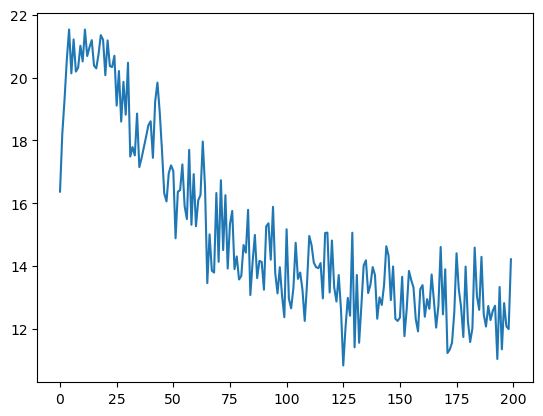

In [370]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 200)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 14.938029587072903
Last epoch loss - 10.6149883227044

Classification report:

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86       184
         1.0       0.76      0.42      0.54       412
         2.0       0.61      0.74      0.67       164
         3.0       0.23      0.98      0.37        58
         4.0       0.49      0.70      0.58       168
         5.0       0.04      1.00      0.07         8
         6.0       0.90      0.20      0.33      1030
         7.0       0.00      0.00      0.00         0
         8.0       0.84      0.65      0.73       286
         9.0       0.82      0.74      0.77       253
        10.0       0.00      0.00      0.00         0
        11.0       0.64      0.97      0.77       152
        12.0       0.73      0.89      0.80       205
        13.0       0.98      0.28      0.44       801
        14.0       0.00      0.00      0.00         0
        15.0       0.85      0.63    

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

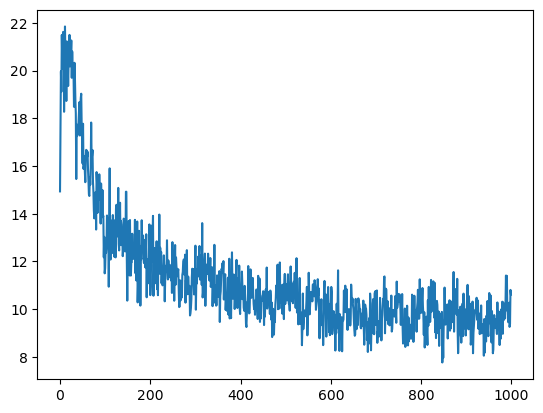

In [371]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 18.62609071561513
Last epoch loss - 10.063037531030915

Classification report:

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82       270
         1.0       0.88      0.29      0.44       699
         2.0       0.80      0.31      0.45       522
         3.0       0.19      0.98      0.32        48
         4.0       0.85      0.41      0.55       495
         5.0       0.87      0.40      0.55       456
         6.0       0.00      0.00      0.00         0
         7.0       0.55      0.29      0.38       412
         8.0       0.80      0.83      0.82       213
         9.0       0.79      0.66      0.72       274
        10.0       0.01      0.50      0.02         4
        11.0       0.44      0.92      0.60       111
        12.0       0.94      0.78      0.85       304
        13.0       0.61      0.95      0.74       149
        14.0       0.00      0.00      0.00         0
        15.0       0.42      0.97   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

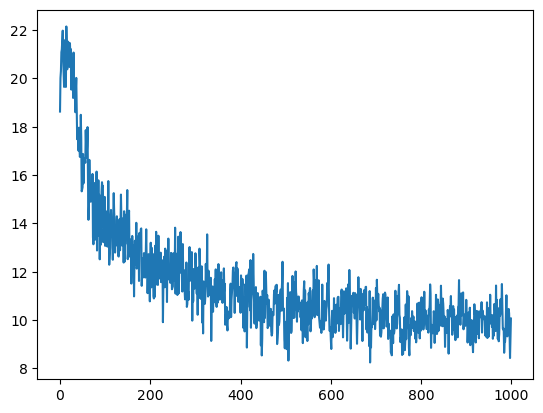

In [387]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.05)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 20.40342628837541
Last epoch loss - 16.376314122071697

Classification report:

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       233
         1.0       0.00      0.00      0.00         0
         2.0       0.68      0.33      0.45       408
         3.0       0.00      0.00      0.00         0
         4.0       0.13      0.33      0.18        90
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.73      0.70      0.72       231
         9.0       0.55      0.98      0.71       129
        10.0       0.00      0.00      0.00         0
        11.0       0.00      0.00      0.00         0
        12.0       0.94      0.26      0.40       926
        13.0       0.00      0.00      0.00        19
        14.0       0.00      0.00      0.00         0
        15.0       0.35      0.98   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

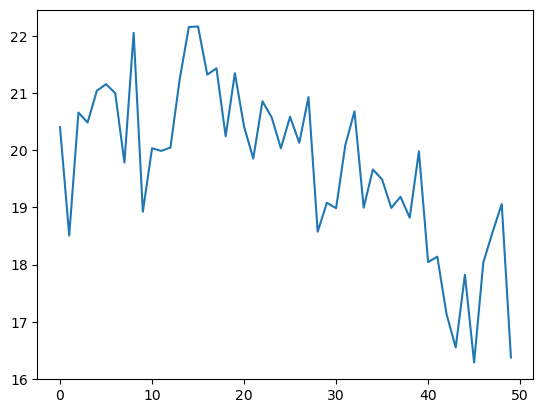

In [378]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 1)
epoch_losses = logRegression.fit(X_train, y_train, 50)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 20.816781526550063
Last epoch loss - 14.460736419819266

Classification report:

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       231
         1.0       0.04      0.17      0.07        58
         2.0       0.92      0.17      0.28      1092
         3.0       0.95      0.17      0.28      1442
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.23      0.28      0.25       179
         8.0       0.20      1.00      0.34        45
         9.0       0.87      0.39      0.54       510
        10.0       0.00      0.00      0.00         0
        11.0       0.83      0.34      0.49       558
        12.0       0.29      0.96      0.45        77
        13.0       0.20      0.82      0.33        57
        14.0       0.00      0.00      0.00         0
        15.0       0.14      1.00  

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

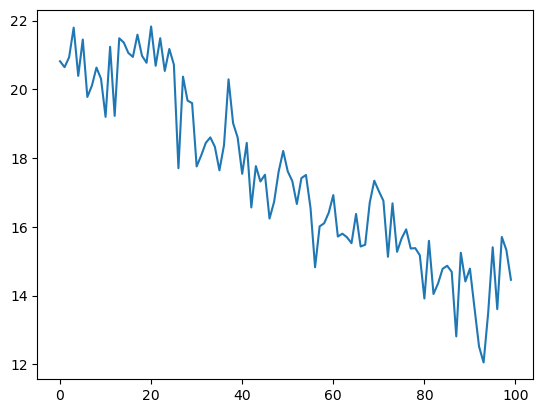

In [380]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.1)
epoch_losses = logRegression.fit(X_train, y_train, 100)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 19.72530049385387
Last epoch loss - 13.730804601923904

Classification report:

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83       234
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.08      0.01        12
         3.0       0.78      0.45      0.57       438
         4.0       0.88      0.18      0.30      1175
         5.0       0.62      0.55      0.58       239
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.75      0.66      0.70       251
         9.0       0.24      1.00      0.38        54
        10.0       0.00      0.00      0.00         0
        11.0       0.65      0.82      0.73       185
        12.0       0.92      0.73      0.82       316
        13.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         0
        15.0       0.57      0.99   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

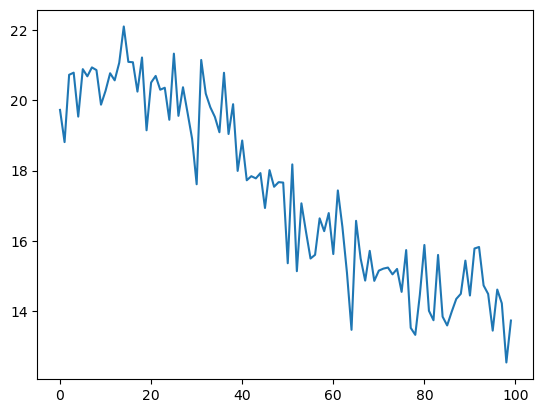

In [382]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 100)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 18.965093283200424
Last epoch loss - 10.458906139914465

Classification report:

              precision    recall  f1-score   support

         0.0       0.90      0.70      0.78       299
         1.0       0.06      0.70      0.11        20
         2.0       0.14      0.39      0.21        74
         3.0       0.90      0.37      0.52       606
         4.0       0.00      0.00      0.00         0
         5.0       0.74      0.57      0.64       273
         6.0       0.00      0.00      0.00         0
         7.0       0.63      0.20      0.30       689
         8.0       0.71      0.91      0.80       173
         9.0       0.64      0.94      0.76       155
        10.0       0.84      0.22      0.34       731
        11.0       0.76      0.67      0.72       261
        12.0       0.58      0.94      0.72       155
        13.0       0.65      0.56      0.60       268
        14.0       0.00      0.00      0.00         0
        15.0       0.59      0.94  

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

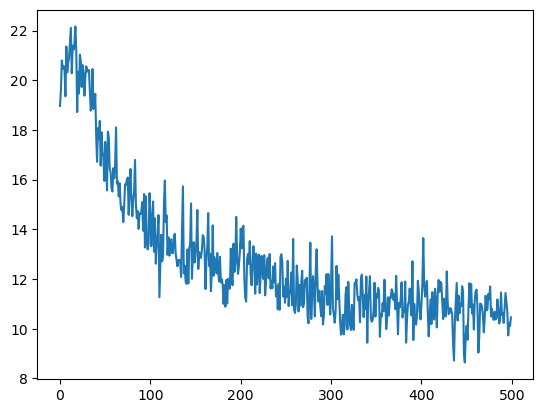

In [385]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 500)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 19.118699557277715
Last epoch loss - 10.750461256728402

Classification report:

              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       242
         1.0       0.90      0.27      0.42       751
         2.0       0.40      0.88      0.55        92
         3.0       0.22      0.96      0.36        57
         4.0       0.68      0.41      0.51       395
         5.0       0.21      0.96      0.34        46
         6.0       0.03      0.32      0.05        19
         7.0       0.00      0.00      0.00         0
         8.0       0.84      0.59      0.69       312
         9.0       0.74      0.84      0.79       201
        10.0       0.00      0.00      0.00         0
        11.0       0.70      0.80      0.75       201
        12.0       0.89      0.87      0.88       259
        13.0       0.83      0.70      0.76       276
        14.0       0.94      0.18      0.30      1146
        15.0       0.80      0.74  

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

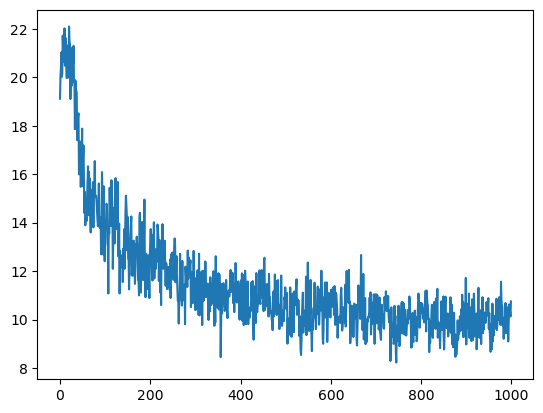

In [386]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 20.956257612459364
Last epoch loss - 19.207336404643137


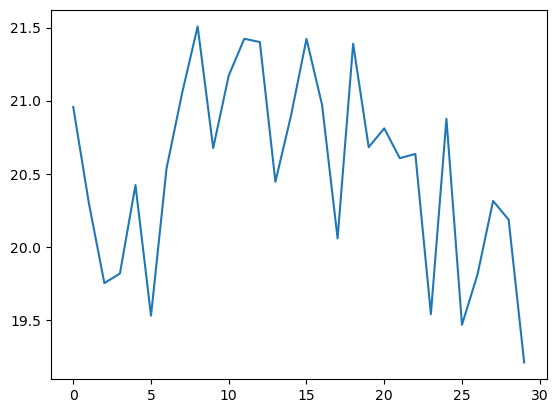

In [302]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 30)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

First epoch loss - 20.08383349002504
Last epoch loss - 14.297620479354213


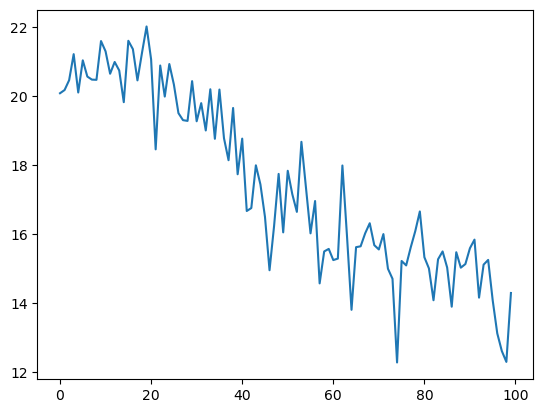

In [303]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 100)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

First epoch loss - 17.6879929634801
Last epoch loss - 14.389525746062612


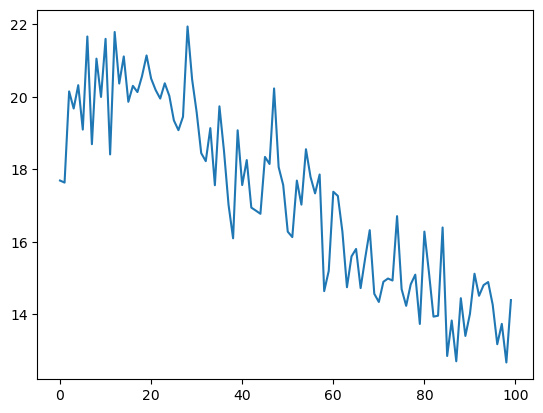

In [306]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 100)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

First epoch loss - 9.012073902437491
Last epoch loss - 10.927538726916309


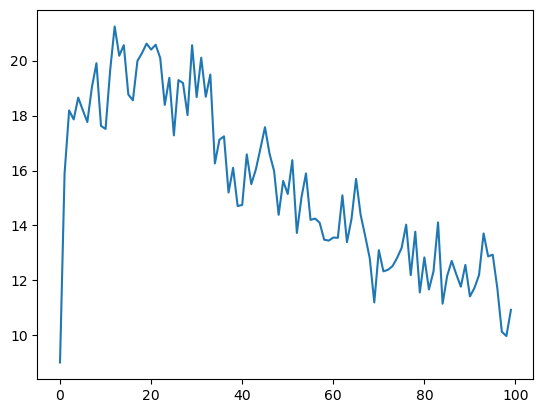

In [307]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.0001)
epoch_losses = logRegression.fit(X_train, y_train, 100)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

First epoch loss - 16.601672510126786
Last epoch loss - 12.374334654321807


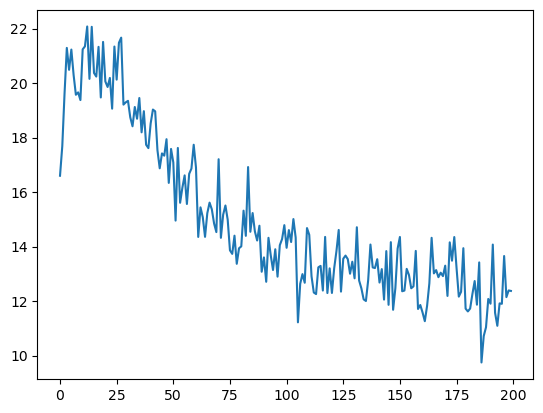

In [308]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 200)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

First epoch loss - 16.639211209933762
Last epoch loss - 15.4437598487


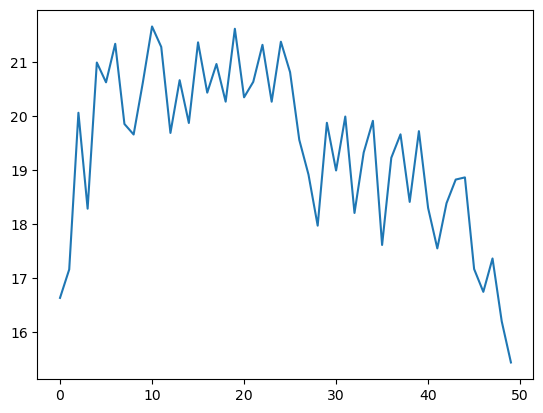

In [315]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 50)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

In [323]:
def indicator_for_arr(arr):
    arr_1d = np.zeros(len(arr))
    for i in range(len(arr)):
        arr_1d[i] = arr[i].argmax()
    return arr_1d

First epoch loss - 16.714019963999093
Last epoch loss - 12.88610532177735

Classification report:

              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       243
         1.0       0.07      0.68      0.13        25
         2.0       0.00      0.00      0.00         0
         3.0       0.23      0.85      0.36        67
         4.0       0.28      0.89      0.43        75
         5.0       0.01      1.00      0.03         3
         6.0       0.51      0.26      0.35       445
         7.0       0.00      0.00      0.00         0
         8.0       0.65      0.90      0.75       159
         9.0       0.65      0.95      0.77       155
        10.0       0.78      0.30      0.43       494
        11.0       0.09      1.00      0.17        21
        12.0       0.79      0.92      0.85       216
        13.0       0.17      0.91      0.29        44
        14.0       0.95      0.11      0.20      1896
        15.0       0.85      0.58   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

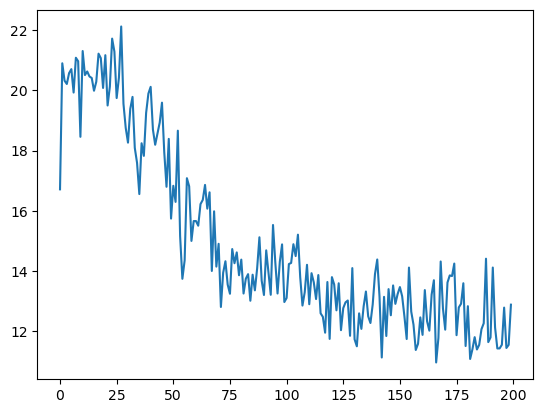

In [326]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 200)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 14.55103658549368
Last epoch loss - 11.090974668857745

Classification report:

              precision    recall  f1-score   support

         0.0       0.92      0.62      0.74       345
         1.0       0.21      0.89      0.34        54
         2.0       0.76      0.30      0.43       517
         3.0       0.66      0.69      0.67       239
         4.0       0.93      0.22      0.36       999
         5.0       0.08      1.00      0.14        16
         6.0       0.33      0.30      0.31       256
         7.0       0.00      0.00      0.00         0
         8.0       0.84      0.80      0.82       232
         9.0       0.74      0.74      0.74       226
        10.0       0.00      0.00      0.00         0
        11.0       0.52      0.90      0.66       132
        12.0       0.91      0.64      0.75       357
        13.0       0.58      0.72      0.65       187
        14.0       0.00      0.00      0.00         0
        15.0       0.88      0.46   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

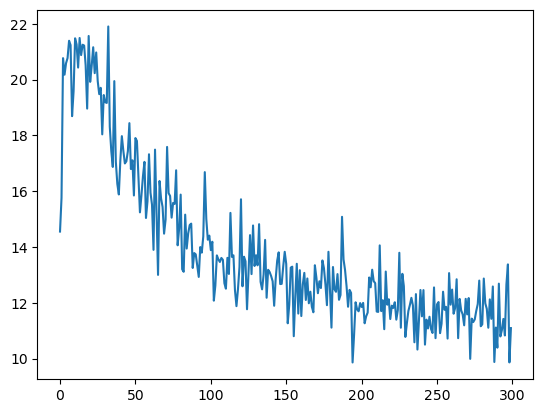

In [327]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.001)
epoch_losses = logRegression.fit(X_train, y_train, 300)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 18.79808043609318
Last epoch loss - 10.49697414868191

Classification report:

              precision    recall  f1-score   support

         0.0       0.93      0.61      0.74       355
         1.0       0.38      0.70      0.49       123
         2.0       0.00      0.00      0.00         0
         3.0       0.81      0.48      0.60       422
         4.0       0.84      0.25      0.38       819
         5.0       0.69      0.61      0.65       238
         6.0       0.00      0.00      0.00         0
         7.0       0.57      0.26      0.36       469
         8.0       0.84      0.64      0.73       292
         9.0       0.75      0.85      0.80       200
        10.0       0.00      0.00      0.00         0
        11.0       0.78      0.54      0.64       334
        12.0       0.78      0.96      0.86       204
        13.0       0.59      0.87      0.70       157
        14.0       0.00      0.00      0.00         0
        15.0       0.65      0.95    

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

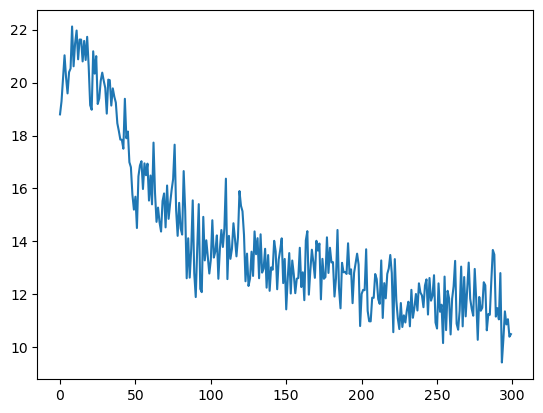

In [328]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 300)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 20.121375120798596
Last epoch loss - 10.332127263104844

Classification report:

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       201
         1.0       0.10      0.83      0.19        29
         2.0       0.75      0.36      0.49       416
         3.0       0.92      0.35      0.50       659
         4.0       0.20      0.49      0.28        96
         5.0       0.82      0.34      0.48       513
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.72      0.83      0.77       193
         9.0       0.77      0.84      0.80       209
        10.0       0.72      0.37      0.49       364
        11.0       0.75      0.81      0.78       214
        12.0       0.86      0.88      0.87       248
        13.0       0.61      0.76      0.68       186
        14.0       0.00      0.00      0.00         0
        15.0       0.55      0.95  

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

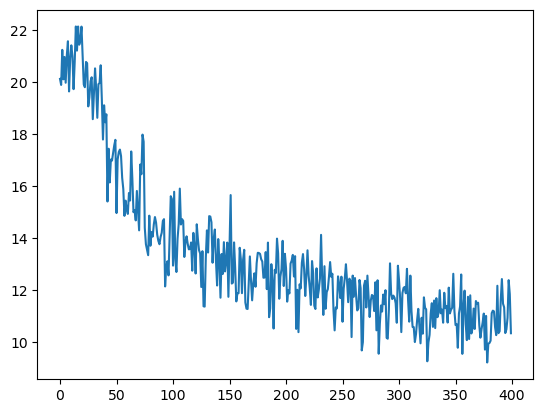

In [329]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 400)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

In [341]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Создание и обучение модели логистической регрессии
model = LogisticRegression(multi_class='multinomial', penalty=None)
model.fit(X_train, indicator_for_arr(y_train))

# Прогнозирование классов на тестовой выборке
y_pred = model.predict(X_test)
y_test_t = indicator_for_arr(y_test)

# Оценка точности модели
accuracy = accuracy_score(y_test_t, y_pred)
print(f"Точность модели: {accuracy}")

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))


Точность модели: 0.7625

Classification report:

              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       247
         1.0       0.74      0.63      0.68       269
         2.0       0.68      0.74      0.71       183
         3.0       0.77      0.77      0.77       250
         4.0       0.73      0.71      0.72       245
         5.0       0.76      0.77      0.76       210
         6.0       0.51      0.57      0.54       204
         7.0       0.39      0.55      0.46       155
         8.0       0.82      0.86      0.84       210
         9.0       0.81      0.79      0.80       232
        10.0       0.70      0.63      0.66       208
        11.0       0.81      0.85      0.83       221
        12.0       0.91      0.90      0.90       255
        13.0       0.82      0.81      0.82       232
        14.0       0.74      0.63      0.68       257
        15.0       0.78      0.87      0.82       221
        16.0       0.70      0.7

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


First epoch loss - 19.575754889291044
Last epoch loss - 11.41036654000678

Classification report:

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       236
         1.0       0.61      0.53      0.57       262
         2.0       0.75      0.34      0.47       447
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.50      0.01         2
         5.0       0.53      0.71      0.60       157
         6.0       0.00      0.00      0.00         0
         7.0       0.62      0.25      0.36       543
         8.0       0.09      1.00      0.17        20
         9.0       0.84      0.48      0.61       400
        10.0       0.01      0.50      0.01         2
        11.0       0.84      0.61      0.70       317
        12.0       0.91      0.83      0.87       277
        13.0       0.59      0.94      0.73       146
        14.0       0.00      0.00      0.00         0
        15.0       0.83      0.73   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

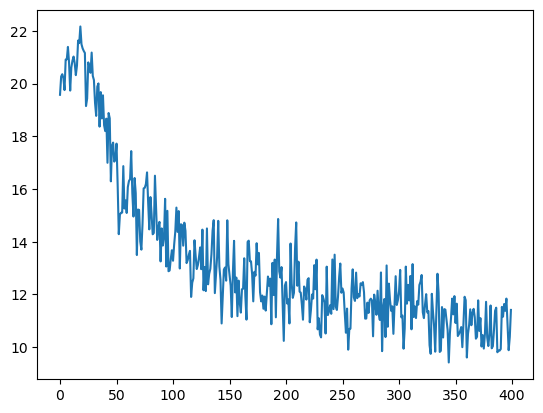

In [342]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 400)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 19.785715123750144
Last epoch loss - 10.411703177949622

Classification report:

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       231
         1.0       0.48      0.72      0.57       152
         2.0       0.72      0.43      0.54       334
         3.0       0.39      0.97      0.56       101
         4.0       0.60      0.61      0.61       231
         5.0       0.89      0.34      0.49       561
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.10      1.00      0.17        21
         9.0       0.75      0.60      0.67       282
        10.0       0.00      0.00      0.00         0
        11.0       0.85      0.63      0.72       314
        12.0       0.96      0.54      0.69       450
        13.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         0
        15.0       0.48      0.93  

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

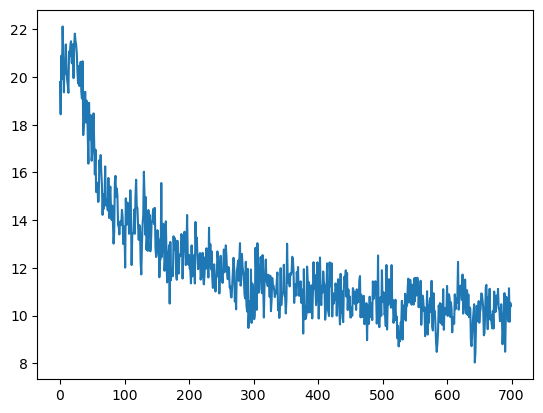

In [343]:

logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 700)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 19.915151508971487
Last epoch loss - 9.994841853464205

Classification report:

              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82       271
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.89      0.42      0.57       531
         4.0       0.93      0.21      0.34      1071
         5.0       0.23      0.91      0.36        53
         6.0       0.01      0.33      0.02         6
         7.0       0.00      0.00      0.00         0
         8.0       0.85      0.48      0.62       389
         9.0       0.81      0.70      0.75       265
        10.0       0.77      0.36      0.49       398
        11.0       0.68      0.72      0.70       219
        12.0       0.82      0.92      0.87       226
        13.0       0.81      0.70      0.75       267
        14.0       0.83      0.40      0.54       447
        15.0       0.69      0.89   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

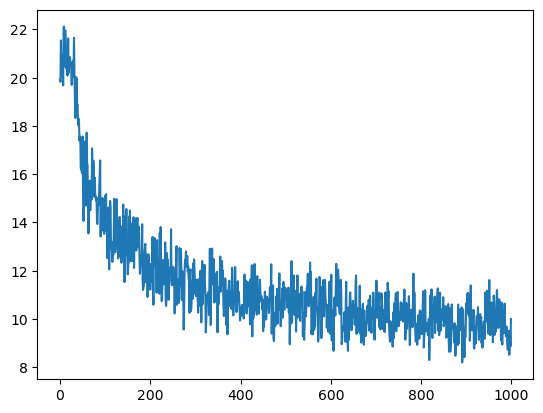

In [344]:
                
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.01)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 19.881151778197626
Last epoch loss - 10.290772438562822

Classification report:

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85       241
         1.0       0.00      0.00      0.00         1
         2.0       0.35      1.00      0.52        71
         3.0       0.44      0.80      0.57       138
         4.0       0.33      0.84      0.47        93
         5.0       0.30      0.94      0.46        68
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.67      0.95      0.79       155
         9.0       0.68      0.81      0.74       191
        10.0       0.69      0.52      0.59       250
        11.0       0.65      0.96      0.77       155
        12.0       0.71      0.96      0.81       185
        13.0       0.84      0.48      0.62       403
        14.0       0.95      0.13      0.22      1655
        15.0       0.77      0.78  

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

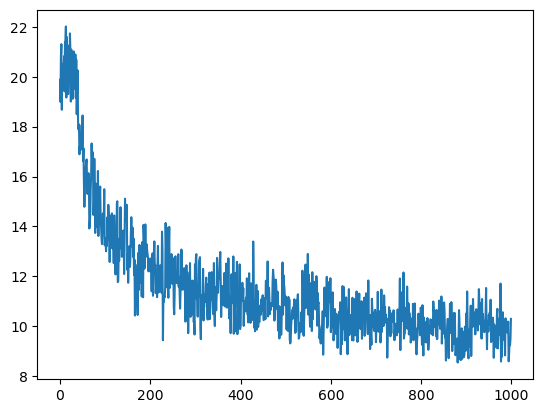

In [345]:
                
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.1)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 20.14532904034115
Last epoch loss - 10.333851735114779

Classification report:

              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84       205
         1.0       0.86      0.38      0.53       512
         2.0       0.56      0.64      0.60       174
         3.0       0.38      0.90      0.54       105
         4.0       0.02      1.00      0.03         4
         5.0       0.01      1.00      0.02         2
         6.0       0.76      0.39      0.52       445
         7.0       0.69      0.30      0.42       509
         8.0       0.77      0.89      0.83       191
         9.0       0.76      0.78      0.77       221
        10.0       0.66      0.49      0.56       255
        11.0       0.41      1.00      0.58        95
        12.0       0.86      0.94      0.90       230
        13.0       0.39      0.92      0.54        97
        14.0       0.09      0.83      0.16        23
        15.0       0.84      0.69   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

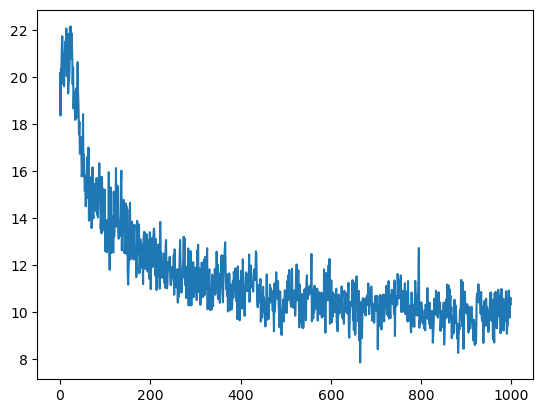

In [346]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.25)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 20.707738025670917
Last epoch loss - 9.61656712612903

Classification report:

              precision    recall  f1-score   support

         0.0       0.93      0.66      0.77       327
         1.0       0.85      0.35      0.49       560
         2.0       0.69      0.49      0.57       282
         3.0       0.87      0.42      0.57       520
         4.0       0.07      1.00      0.13        17
         5.0       0.19      0.98      0.32        42
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.33      0.01         3
         8.0       0.83      0.44      0.58       419
         9.0       0.67      0.85      0.75       179
        10.0       0.68      0.56      0.62       228
        11.0       0.86      0.54      0.67       364
        12.0       0.75      0.93      0.83       204
        13.0       0.89      0.40      0.55       512
        14.0       0.00      0.00      0.00         0
        15.0       0.79      0.75    

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

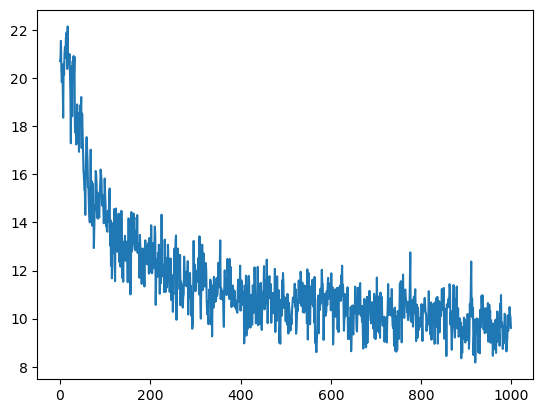

In [347]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.35)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))

First epoch loss - 19.519813108949695
Last epoch loss - 8.531077769480003

Classification report:

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       216
         1.0       0.55      0.77      0.64       166
         2.0       0.67      0.55      0.60       246
         3.0       0.60      0.90      0.72       166
         4.0       0.89      0.33      0.48       644
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.50      0.50      0.50       222
         8.0       0.81      0.75      0.78       237
         9.0       0.79      0.76      0.77       235
        10.0       0.12      0.79      0.21        29
        11.0       0.80      0.72      0.75       257
        12.0       0.90      0.89      0.90       255
        13.0       0.59      0.99      0.74       137
        14.0       0.73      0.59      0.65       270
        15.0       0.84      0.63   

/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khumachbayramova/anaconda3/envs/linear-models/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

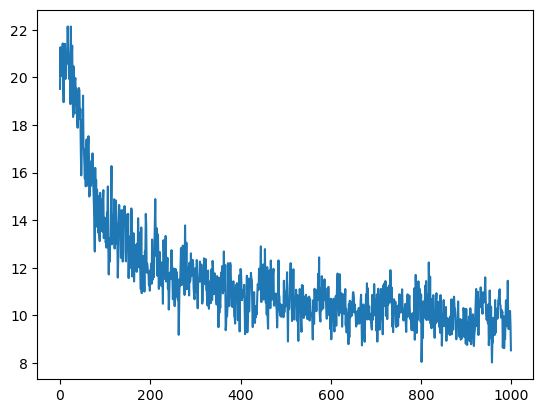

In [348]:
logRegression = VasKhumLogisticRegression(feature_num, classes_num, 0.5)
epoch_losses = logRegression.fit(X_train, y_train, 1000)
# nn.feedforward(X_train.iloc[0].values)
# nn._backprop(pd.DataFrame(y_train_two_outs).iloc[0].values)
plt.plot(epoch_losses)
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

y_pred_raw = logRegression.predict(X_test)
from sklearn.metrics import classification_report

y_pred = indicator_for_arr(y_pred_raw)
y_test_t = indicator_for_arr(y_test)

print('\nClassification report:\n')
print(classification_report(y_pred, y_test_t))